<a href="https://colab.research.google.com/github/rachel-kim2255/SQL_customer_behavior_analysis/blob/main/e_commerce_olist_rachel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛒 **E-commerce Customer Behavior & RFM Analysis**

👉 **Tip:** For best experience, open this notebook in **Google Colab** and use the **Table of Contents panel (on the left)** to quickly navigate between sections.  

[Colab Link](https://colab.research.google.com/drive/1m7jj_-TjM4LRgpsv4pqdmf0OqgmeHnRs?usp=sharing)

<br>

---
<br>



# **1. Executive Summary**

### About the Analysis
This notebook presents a complete workflow of **RFM-based customer segmentation** using the Olist Brazilian e-commerce dataset.  
It covers data preparation, segmentation, visualization, and business insights with actionable strategies.  

### About the Dataset
- **Source:** [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)  
- **Period:** *2016-09-15 ~ 2018-08-29* (based on successfully delivered orders)  
- **Size:** ~100k orders across multiple marketplaces in Brazil  

The dataset includes order status, prices, payments, delivery performance, customer location, product attributes, and reviews.  
Data is anonymized; company and partner names have been replaced with placeholders (e.g., Game of Thrones houses).  

### References
- [Dataset Reference](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)  
- [Example Analysis](https://www.kaggle.com/code/arvinthsss/brazilian-e-commerce-dive-deep-using-sql)

# **2.Database Setting**

In [146]:
# Dataset: Olist (SQLite) from Kaggle via kagglehub
import kagglehub

# Download latest version of the dataset
dataset_path = kagglehub.dataset_download("terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database")
print("Dataset downloaded to:", dataset_path)

# Connect to the SQLite database
import sqlite3
db_path = f"{dataset_path}/olist.sqlite"
conn = sqlite3.connect(db_path)


# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import re
import math
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated*")


# Visualization Setup
import seaborn as sns
import matplotlib.pyplot as plt


# View sample data
def view_table(table_name, limit=5):
    query = f"SELECT * FROM {table_name} LIMIT {limit}"
    return pd.read_sql_query(query, conn)


# Preview sample tables
display(view_table('orders'))
display(view_table('customers'))


Using Colab cache for faster access to the 'e-commerce-dataset-by-olist-as-an-sqlite-database' dataset.
Dataset downloaded to: /kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


# **3.Data Understanding**

## 3-1. Database Schema

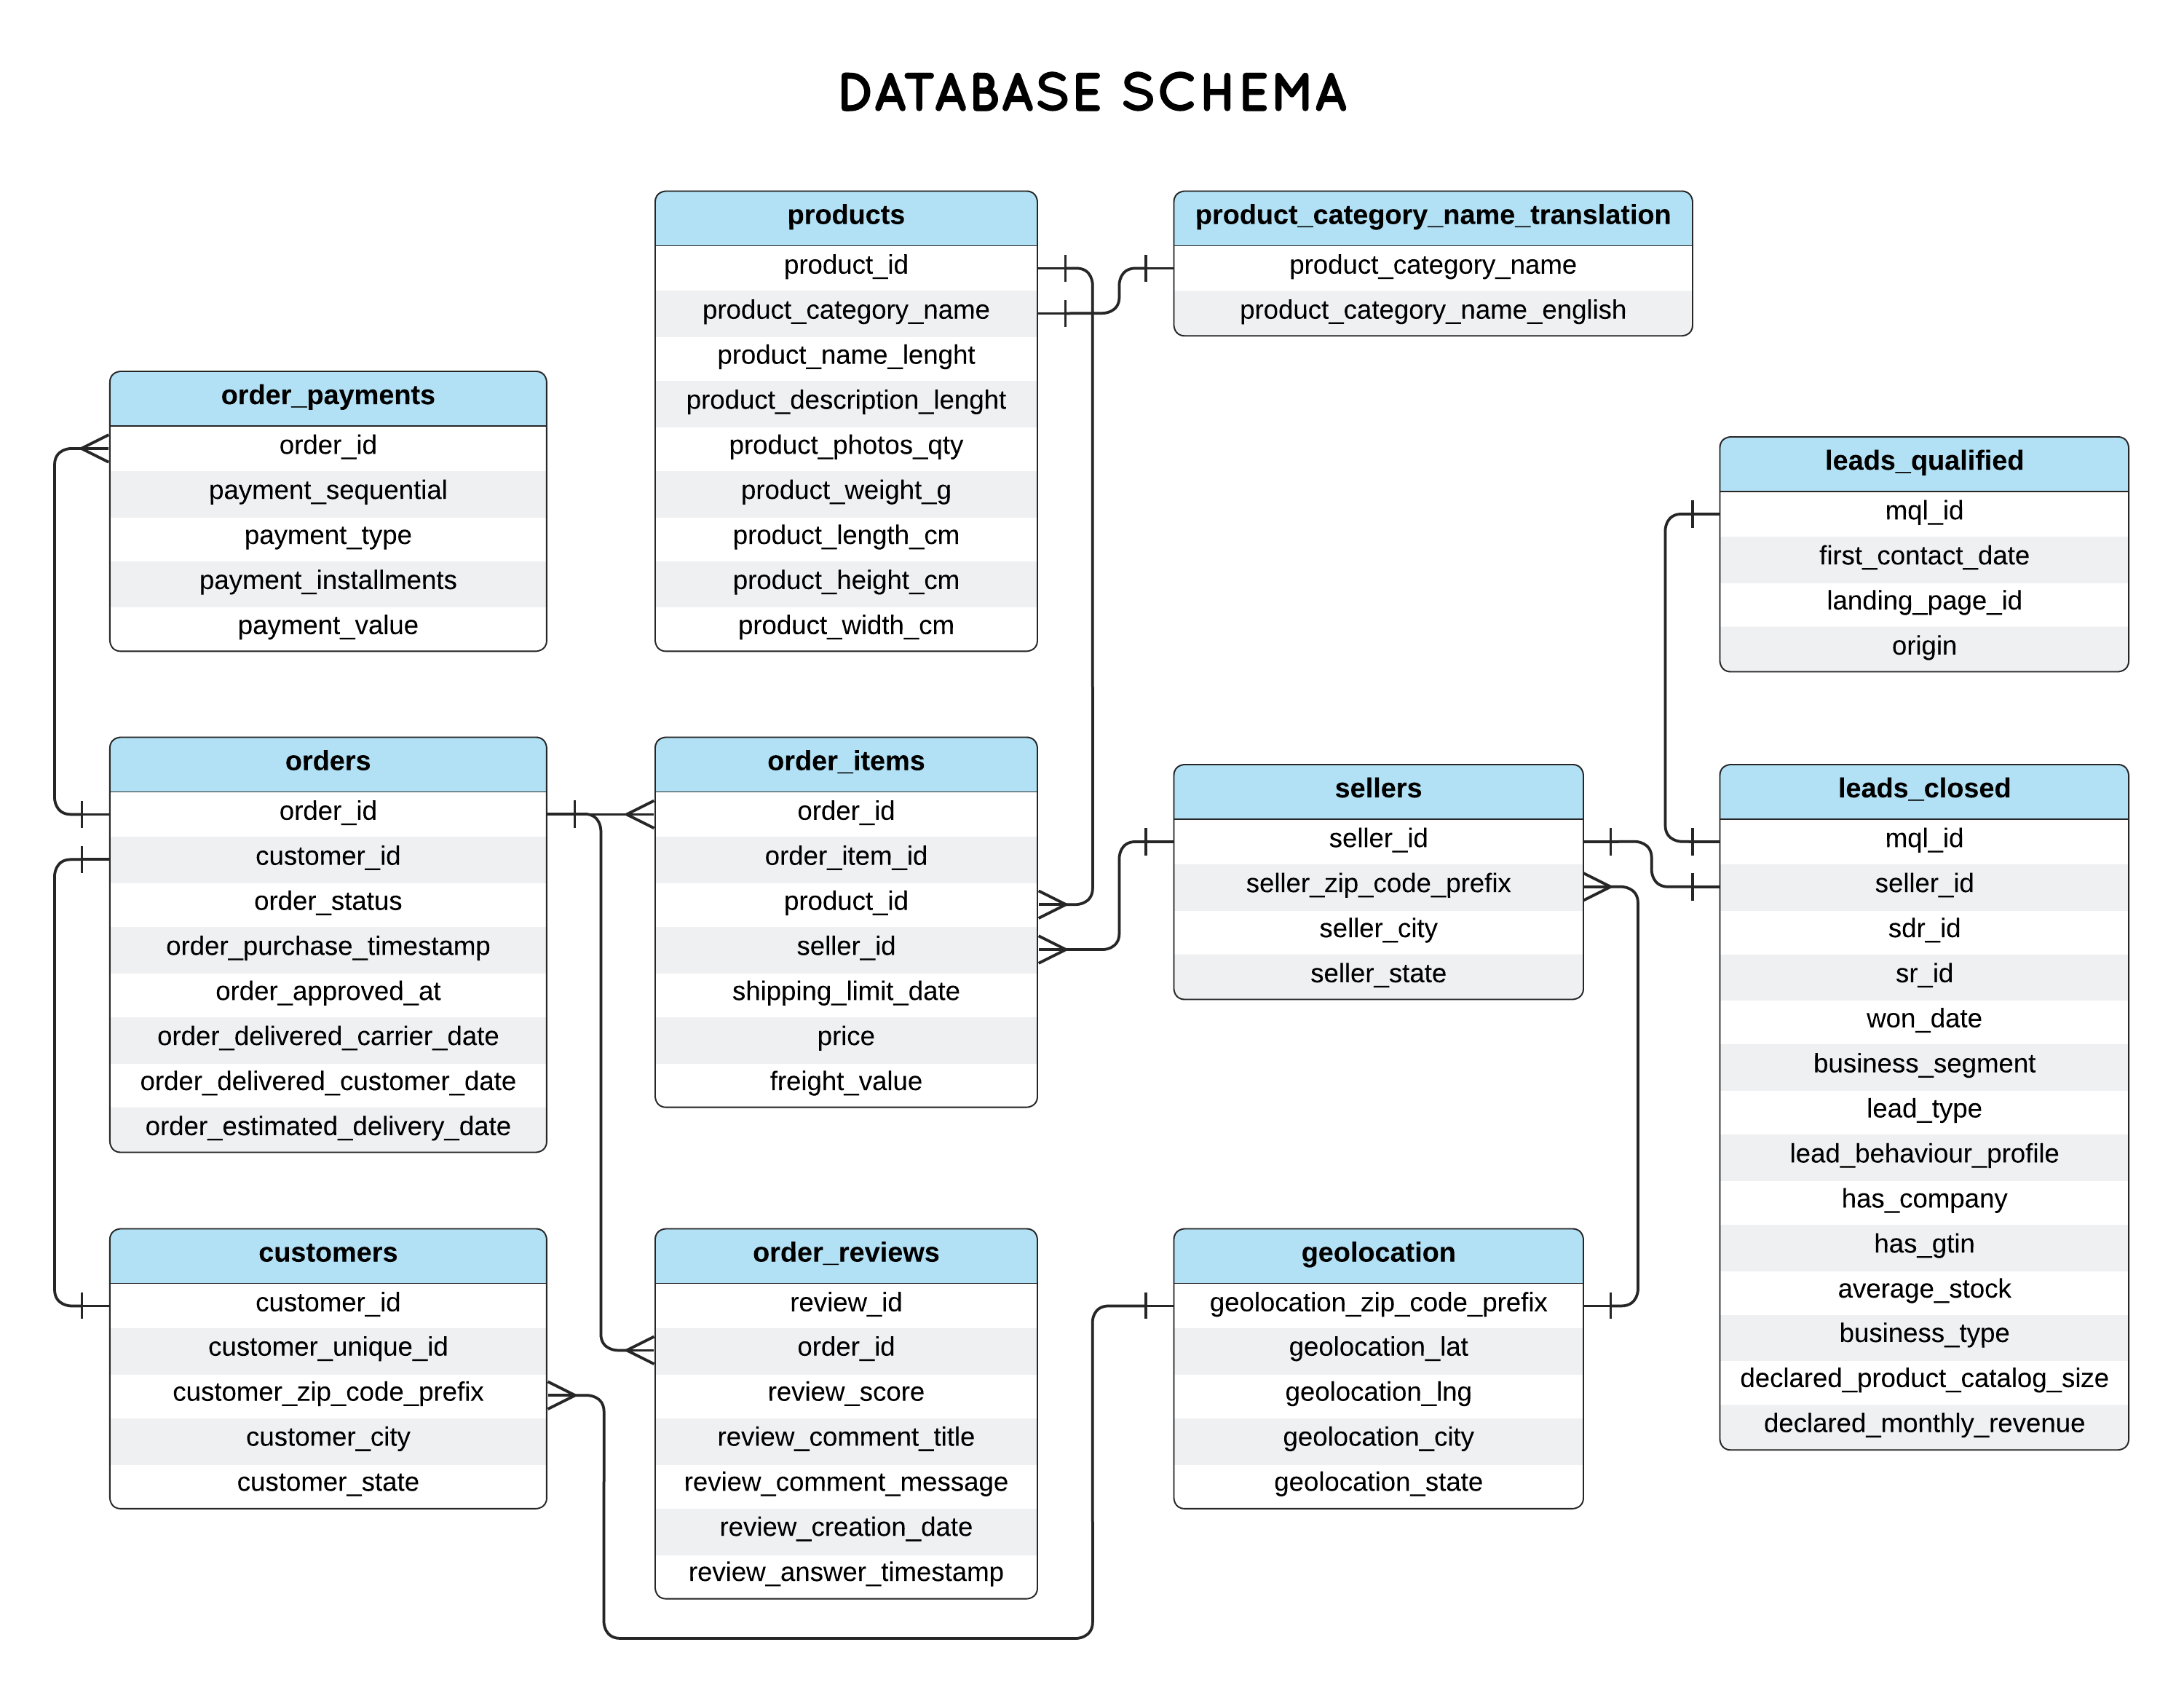

### 📦 Dataset Structure Overview: Olist E-commerce  
This project uses the Olist Brazilian E-commerce dataset in SQLite format. The database includes multiple relational tables that capture the full customer journey, from product listing and purchase to delivery, payment, and review.  
<br>

**Main E-commerce Tables**  
- **orders**: Contains order-level information such as status, purchase and delivery timestamps, and customer ID.  
- **order_items**: Line-item details for each order, including product ID, seller ID, price, and freight cost.  
- **order_reviews**: Customer reviews per order, including review score, comment content, and creation date.  
- **order_payments**: Payment method, number of installments, and amount paid per order.  
<br>

**Customer & Seller Tables**  
- **customers**: Customer location and anonymized ID, enabling segmentation by region.  
- **sellers**: Seller information including geographic location (ZIP code prefix, city, state).  
<br>

**Product Information**  
- **products**: Product attributes such as category, physical dimensions, description length, and image count.  
- **product_category_name_translation**: Mapping table for translating product categories from Portuguese to English.  
<br>

**Location & Mapping**  
- **geolocation**: ZIP code-level mapping to latitude/longitude, city, and state for geospatial analysis.  
<br>

**B2B Sales Funnel**  
- **leads_qualified**: Initial lead information from marketing channels, including contact date and origin.  
- **leads_closed**: Sales-qualified leads with conversion status, seller info, business profile, and estimated revenue.  


## 3-2. Dataset Info

In [147]:
# Dataset Info
query = '''
SELECT
    COUNT(DISTINCT o.order_id) AS total_orders,
    COUNT(DISTINCT c.customer_unique_id) AS unique_customers,
    ROUND(SUM(p.payment_value), 2) AS total_revenue,
    MIN(o.order_purchase_timestamp) AS start_date,
    MAX(o.order_purchase_timestamp) AS end_date
FROM  orders as o JOIN customers as C
      ON o.customer_id = c.customer_id
      JOIN order_payments as P
      ON o.order_id = p.order_id
WHERE order_status = 'delivered';
'''

period = pd.read_sql_query(query, conn)
period

,total_orders,unique_customers,total_revenue,start_date,end_date
0,96477,93357,15422461.77,2016-10-03 09:44:50,2018-08-29 15:00:37


>Dataset Volume: **96,477**  
>Total Revenue: **15M BRL (~4.16M CAD)**  
>Dataset Period: **2016.10.03 - 2018.08.29 (~2yrs)**  
>*based on purchase behavior involving successfully delivered orders.

## 3-3. Table Preview

In [148]:
# Display all tables, columns, datatypes
for table in ['orders', 'customers', 'order_items', 'order_payments', 'order_reviews',
              'product_category_name_translation', 'sellers', 'geolocation',
              'leads_qualified', 'leads_closed']:
    print(f"📌 {table}")

    df = view_table(table)
    display(df)
    print("Data Types:")
    print(df.dtypes)
    print("\n" + "="*100 + "\n")

📌 orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Data Types:
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


📌 customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Data Types:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


📌 order_items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Data Types:
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object


📌 order_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Data Types:
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


📌 order_reviews


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Data Types:
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object


📌 product_category_name_translation


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Data Types:
product_category_name            object
product_category_name_english    object
dtype: object


📌 sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


Data Types:
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object


📌 geolocation


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Data Types:
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object


📌 leads_qualified


,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


Data Types:
mql_id                object
first_contact_date    object
landing_page_id       object
origin                object
dtype: object


📌 leads_closed


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,None,None,None,reseller,None,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,None,None,None,reseller,None,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,None,None,None,reseller,None,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,None,None,None,None,reseller,None,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,None,None,None,manufacturer,None,0.0


Data Types:
mql_id                            object
seller_id                         object
sdr_id                            object
sr_id                             object
won_date                          object
business_segment                  object
lead_type                         object
lead_behaviour_profile            object
has_company                       object
has_gtin                          object
average_stock                     object
business_type                     object
declared_product_catalog_size     object
declared_monthly_revenue         float64
dtype: object




>✔️ **Check Point**  
>1. **customer_id** and **customer_unique_id** are used for different purposes.
>
>  - **customer_id**: A customer **identifier used at the order level**. Since the same customer may appear with different customer_ids across multiple orders, this field can lead to duplication in customer-level analysis.
>
>  - **customer_unique_id**: **A unique identifier for each customer**, consistent across all orders. This is used for person-level analysis such as repeat purchase behavior and lifetime value (LTV) calculations.
>
>2. **About Data type**: I did not pre-convert all data types after loading the data into Pandas.
Instead, I applied on-demand conversions only for columns used in analysis or visualization.
Since SQLite defines data types explicitly, date and numeric operations work reliably within SQL queries.
Even if some fields are loaded as object in Pandas, they can be flexibly handled as needed during the analysis.





# **4. Customer Purchase Behavior**

> ### **🔎 Questions**
>
>- How many orders has each customer placed in total?
>- What is the total monetary value spent by each customer?
>- What is the average basket size (number of items per order) for each customer?

## 4-1. How many orders has each customer placed in total?
>### 📍 **Purpose**  
Identifies customer activity level and helps segment users into one-time, occasional, or frequent buyers. This is fundamental for retention analysis and loyalty program targeting.

### **📂 SQL**

In [149]:
# ---- a. Count total orders of each customer --- #
query = '''
SELECT
    c.customer_unique_id AS ID,
    COUNT(DISTINCT o.order_id) AS total_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date
FROM  customers AS c JOIN orders AS o
      ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
ORDER BY total_orders DESC
LIMIT 10;
'''

first_last_order = pd.read_sql_query(query, conn)
first_last_order

,ID,total_orders,first_order_date,last_order_date
0,8d50f5eadf50201ccdcedfb9e2ac8455,15,2017-06-18 22:56:48,2018-08-20 19:14:26
1,3e43e6105506432c953e165fb2acf44c,9,2017-09-18 18:53:15,2018-02-27 18:36:39
2,ca77025e7201e3b30c44b472ff346268,7,2017-10-09 12:34:39,2018-06-01 11:38:29
3,6469f99c1f9dfae7733b25662e7f1782,7,2017-09-19 01:02:44,2018-06-28 00:43:34
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7,2017-11-13 16:44:41,2018-02-14 13:22:12
5,f0e310a6839dce9de1638e0fe5ab282a,6,2017-05-20 08:53:30,2018-04-05 09:04:45
6,dc813062e0fc23409cd255f7f53c7074,6,2017-07-01 04:22:21,2018-08-23 00:07:26
7,63cfc61cee11cbe306bff5857d00bfe4,6,2017-05-11 14:39:53,2018-05-28 17:20:02
8,47c1a3033b8b77b3ab6e109eb4d5fdf3,6,2017-08-07 14:14:22,2018-01-24 15:15:26
9,12f5d6e1cbf93dafd9dcc19095df0b3d,6,2017-01-05 14:18:03,2017-01-05 15:25:10


In [150]:
# ---- b. Average total orders of customers --- #

query2 = '''
SELECT
    ROUND(AVG(total_orders), 2) AS average_total_orders
FROM (
    SELECT
    c.customer_unique_id AS ID,
    COUNT(DISTINCT o.order_id) AS total_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date
    FROM  customers AS c JOIN orders AS o
          ON c.customer_id = o.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
)
'''

avg_total_orders = pd.read_sql_query(query2, conn)
avg_total_orders


,average_total_orders
0,1.03


> 🔎 **Observation**
>- The most purchased count is **15** and the average order count of all customers is **1.03**.


### 📊 **Top 10 Customer's Order Periods**

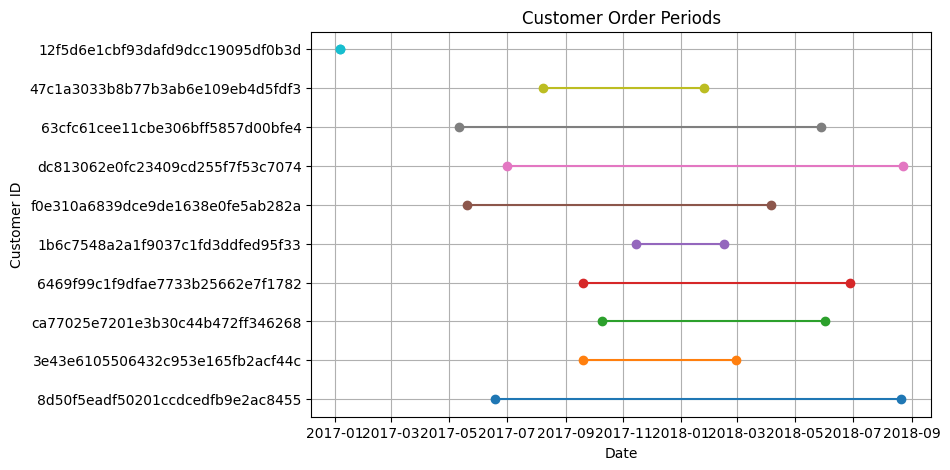

In [151]:
top10_df = pd.read_sql_query(query, conn)

top10_df['first_order_date'] = pd.to_datetime(top10_df['first_order_date'])
top10_df['last_order_date'] = pd.to_datetime(top10_df['last_order_date'])

plt.figure(figsize=(8, 5))
for i, row in top10_df.iterrows():
    plt.plot([row['first_order_date'], row['last_order_date']], [i, i], marker='o')
plt.yticks(range(len(top10_df)), top10_df['ID'])
plt.title('Customer Order Periods')
plt.xlabel('Date')
plt.ylabel('Customer ID')
plt.grid(True)
plt.show()

> 🔎 **Observation**
>- This chart shows the activity period of top 10 customers, allowing us to see **which customers are consistently purchasing.**  
>- Interesting activity is observed from customer '12f5d6e1cbf93dafd9dcc19095df0b3d'. **The customer appears to have ranked among the top 10 based on purchases made in a single day.** Let's investigate how this happened.

In [152]:
# checking the orders from customer '12f5d6e1cbf93dafd9dcc19095df0b3d'
query3 = '''
SELECT
    c.customer_unique_id,
    o.order_id,
    o.order_purchase_timestamp,
    o.order_status
FROM customers AS c
JOIN orders AS o ON c.customer_id = o.customer_id
WHERE c.customer_unique_id = '12f5d6e1cbf93dafd9dcc19095df0b3d'
ORDER BY o.order_purchase_timestamp
'''

df = pd.read_sql_query(query3, conn)
df

,customer_unique_id,order_id,order_purchase_timestamp,order_status
0,12f5d6e1cbf93dafd9dcc19095df0b3d,8a784d47854e4cbc5562362393d504db,2017-01-05 14:18:03,delivered
1,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,2017-01-05 14:22:02,delivered
2,12f5d6e1cbf93dafd9dcc19095df0b3d,ca5a215980675471f0cf8199c041909a,2017-01-05 14:23:54,delivered
3,12f5d6e1cbf93dafd9dcc19095df0b3d,17fed53ba6dfef9b594ee2268642e2aa,2017-01-05 14:50:54,delivered
4,12f5d6e1cbf93dafd9dcc19095df0b3d,464de32dc84484c1d26df3e8e38e708b,2017-01-05 15:25:04,delivered
5,12f5d6e1cbf93dafd9dcc19095df0b3d,747996a66f5aa711deb8ae58f5ae46a0,2017-01-05 15:25:10,delivered


> 🔎 **Observation**
>- This customer truely ordered 6 times in a day. Interesting.

## 4-2. What is the total monetary value spent by each customer?

> ### **📍 Purpose**
>Evaluates customer lifetime value (CLV/LTV) and revenue contribution. High spenders can be prioritized for premium service, promotions, or upsell opportunities.



### **📂 SQL(1) - Overview of All Customer**


First, let’s explore all customers’ total payments and last order dates to understand the overall activation.

In [153]:
# ====================================================================================
# --!! Sample query for retrieving each customer's total spending and last order date
# --!! LIMIT is applied here only to limit preview output.
# --!! Full dataset is used in visualizations below.
# ====================================================================================

# All customer's total payments, last order dates
query = '''
SELECT
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(p.payment_value), 2) AS total_payment
FROM  orders AS o JOIN order_payments AS p
      ON o.order_id = p.order_id
      JOIN customers as c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY  c.customer_unique_id
LIMIT 10
'''

total_payment = pd.read_sql_query(query, conn)
total_payment['last_order_date'] = pd.to_datetime(total_payment['last_order_date']) # Change 'last_order_date's data type from string to date
total_payment

,customer_unique_id,last_order_date,total_payment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,196.89
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,166.98
6,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,35.38
7,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41,419.18
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,150.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2018-03-12 15:22:12,129.76


### 📊 **Total Customer's Spending Distribution**

>To understand how total spending is distributed across all customers, I plotted a histogram of total_payment using a logarithmic scale on the x-axis.
>
>**Why Log Scale?**
>- The spending values vary widely, with most customers spending relatively small amounts and a few spending significantly more.
>- A regular histogram would be skewed, compressing most of the bars to the left and making it hard to interpret.
>- Using a logarithmic scale helps compress low-value data and expand high-value ranges, making it easier to interpret skewed distributions at a glance.  

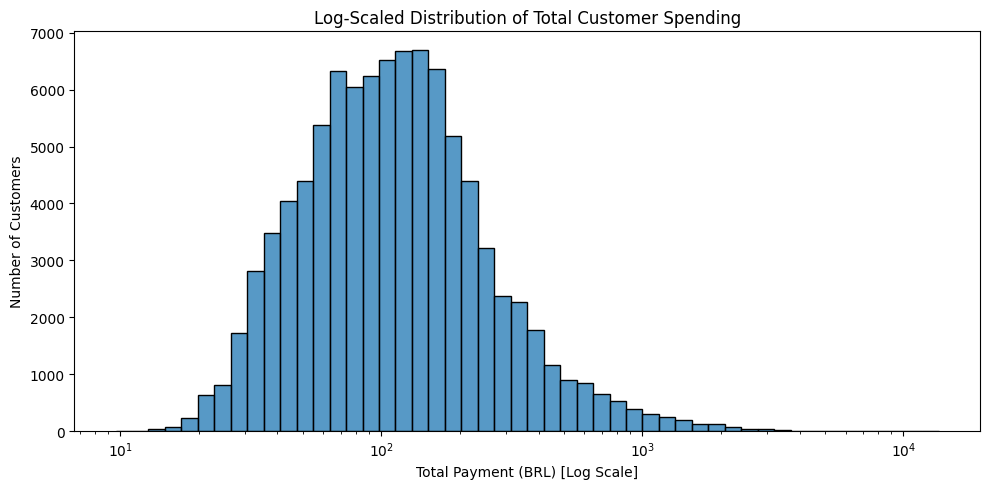

In [154]:
# All customer's Total Payment
query = '''
SELECT
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(p.payment_value), 2) AS total_payment
FROM  orders AS o
JOIN order_payments AS p ON o.order_id = p.order_id
JOIN customers AS c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
'''
total_payment = pd.read_sql_query(query, conn)
total_payment['last_order_date'] = pd.to_datetime(total_payment['last_order_date'])


# Log-Scaled All customer's spending
plt.figure(figsize=(10, 5))
sns.histplot(total_payment['total_payment'], bins=50, log_scale=True)
plt.title('Log-Scaled Distribution of Total Customer Spending')
plt.xlabel('Total Payment (BRL) [Log Scale]')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

> 🔎 **Observation**
>- The **x-axis represents each customer’s total payment**, and the **y-axis shows the number of customers** within each spending range.
>- The x-axis is shown in logarithmic scale, where 10¹ = 10 BRL, 10³ = 1000 BRL, etc.
>- **Most customers spent less than 1000 BRL(approximately 250 CAD),** while only a few customers made significantly higher payments.
>- Due to the log scale, the distribution of high-spending customers is less visually prominent. To explore these customers more closely, I will filter the top 20 customers and create a separate visualization below.

>🔎 **Is it a bad sign that most customers spent less than 1,000 BRL?**  
>1. **No — It can be normal depending on the business model.**   
>In many e-commerce platforms like Amazon that focus on daily essentials or fast-moving consumer goods, it is common for customers to place multiple small orders.
In such cases, a low total spending per customer doesn't necessarily indicate low value — **purchase frequency and retention are more important metrics.**
>
>2. **Yes — If the platform focuses on high-ticket items.**  
>If Olist primarily sells expensive items like electronics or furniture, a majority of customers spending less than 1,000 BRL (about 250CAD) could be a red flag.
This may indicate that **many customers are one-time buyers, which suggests issues with customer retention or loyalty.**
>
>3. **Yes — If the customer acquisition cost (CAC) is high.**  
>In businesses where it’s expensive to acquire each new customer (e.g., via ads, promotions, onboarding), it becomes crucial that those customers generate enough revenue over time.
If the customer lifetime value (LTV) remains low, it fails to offset CAC, leading to poor unit economics and long-term profitability issues.
Even if the number of customers grows, low-spending behavior can erode margins and slow sustainable growth.




>💡 **Insight**  
>- While the majority of customers spent under 1,000 BRL, this distribution may reflect a typical behavior in marketplaces with high transaction volume but low average basket size.
>- However, if the business model relies on high-margin or recurring purchases, this could suggest under-monetization of the customer base, and warrants further investigation into retention, repeat rate, and LTV–CAC ratio.

### 📊 **Total Customer's Last Order Date Distribution**

>To understand the activity patterns of all customers, I visualized the distribution of their last order dates using a KDE plot.
>
>**Why KDE plot?**
>- A KDE(Kernel Density Estimate) plot provides a smoothed version of a histogram, **making it easier to observe the overall distribution shape without being affected by bin size or noise.**
>- In this case, it helps identify **when customers were most actively placing their final orders over time.**

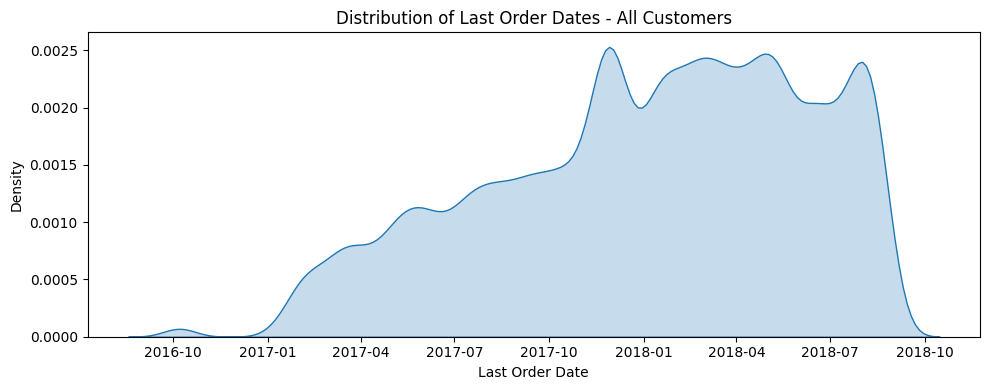

In [155]:
# KDE plot for visualization
plt.figure(figsize=(10, 4))
sns.kdeplot(data=total_payment, x='last_order_date', fill=True)
plt.title('Distribution of Last Order Dates - All Customers')
plt.xlabel('Last Order Date')
plt.tight_layout()
plt.show()

> 💡 **Insights**  
>- The KDE curve shows that most customers’ last orders were concentrated between **early 2017 and mid-2018, with a noticeable peak around late 2017.**
>- **The sharp drop after August 2018** suggests a decline in customer activity.  
>- This insight could **inform churn analysis** or **help identify when engagement strategies might have been most effective.**

### **📂 SQL(2) - Top 20 Customers by Total spending**

In [156]:
# The highest 20 total payments, last order dates
query = '''
SELECT
    c.customer_unique_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(p.payment_value), 2) AS total_payment
FROM  orders AS o JOIN order_payments AS p
      ON o.order_id = p.order_id
      JOIN customers as c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY  c.customer_unique_id
ORDER BY  total_payment DESC
LIMIT 20
'''

total_payment_20 = pd.read_sql_query(query, conn)
total_payment_20['last_order_date'] = pd.to_datetime(total_payment_20['last_order_date']) # Change 'last_order_date' data type string to date
total_payment_20

,customer_unique_id,last_order_date,total_payment
0,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,2017-04-01 15:58:41,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,2018-07-15 14:49:44,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:37:36,6929.31
4,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,6922.21
5,ff4159b92c40ebe40454e3e6a7c35ed6,2017-05-24 18:14:34,6726.66
6,4007669dec559734d6f53e029e360987,2017-11-24 11:03:35,6081.54
7,eebb5dda148d3893cdaf5b5ca3040ccb,2017-04-18 18:50:13,4764.34
8,48e1ac109decbb87765a3eade6854098,2018-06-22 12:23:19,4681.78
9,c8460e4251689ba205045f3ea17884a1,2018-08-08 14:27:15,4655.91


### 📊 **Top 20 Customers by Total spending**

/tmp/ipython-input-2650329094.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_payment_20['customer_unique_id'].str[:6], y=total_payment_20['total_payment'], palette='viridis')


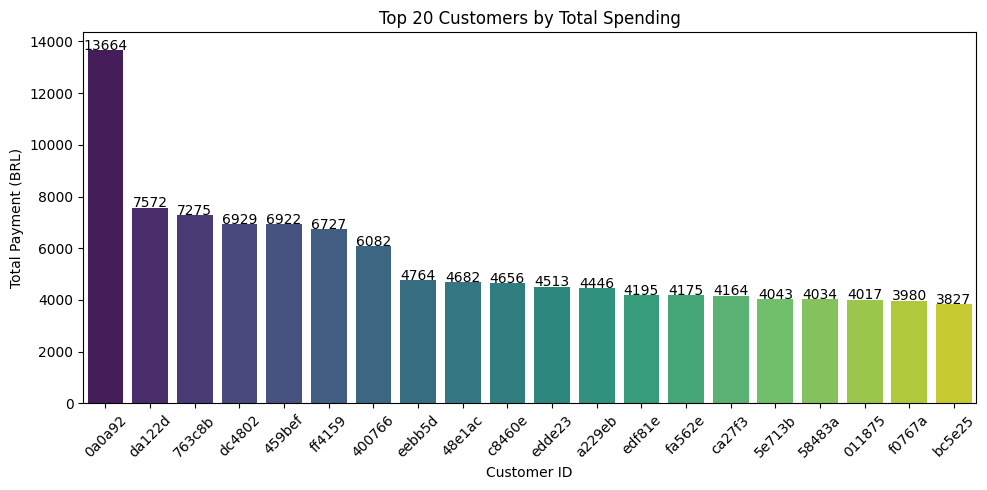

In [157]:
plt.figure(figsize=(10, 5))
sns.barplot(x=total_payment_20['customer_unique_id'].str[:6], y=total_payment_20['total_payment'], palette='viridis')

for index, row in total_payment_20.iterrows():
    plt.text(x=index,
             y=row['total_payment'] + 10,
             s=f"{row['total_payment']:.0f}",
             ha='center')

plt.title('Top 20 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Payment (BRL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> 🔎 **Observation**  
>- The highest spending is **13,664 BRL(approx. 3,416 CAD)**, and 20th spending is **3,827 BRL(approx. 957 CAD)**.
>- The top customer spent 13,664 BRL, which is nearly double the amount spent by the second-highest spender (7,572 BRL).
>- The difference in spending between the 2nd and the 20th customer is less steep, ranging from 7,572 to 3,827 BRL.

> 💡 **Insights**  
>- Even distribution from 2nd to 20th suggests that top customers are more evenly distributed in their spending, which is a healthy signal of customer value diversification.
>- The fact that A customer needs to spend at least 3,827 BRL to be in the top 20 could be used as a threshold for VIP segmentation or targeted campaigns (e.g. loyalty rewards or retention offers).
>- If any of these top 20 customers have been inactive recently (based on last order date), they represent high-value reactivation opportunities.

### 📊 **Top 20 Customer's Last Order Timeline**



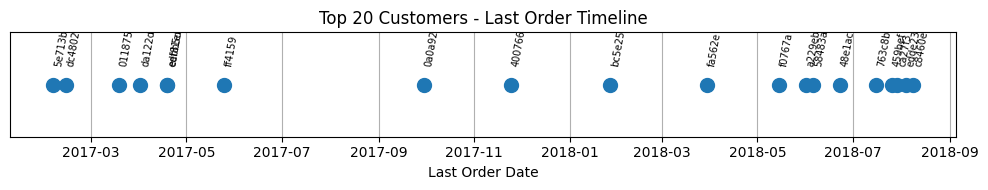

In [158]:
plt.figure(figsize=(10, 2))
plt.scatter(total_payment_20['last_order_date'], [1]*len(total_payment_20), s=100)

for i, row in total_payment_20.iterrows():
    plt.text(row['last_order_date'], 1.02, row['customer_unique_id'][:6], rotation=80, ha='left', size=7)

plt.title('Top 20 Customers - Last Order Timeline')
plt.yticks([])
plt.xlabel('Last Order Date')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

> 💡 **Insights**  
The timeline reveals that **15 out of the top 20 customers have not made any recent purchases**, with the majority of their last orders concentrated **between early 2017 and mid-2018.**
This suggests that **even high-value customers may have become inactive, highlighting a potential opportunity for re-engagement campaigns or a redesign of the loyalty program.**

## 4-3. What is the average basket size for each customer?

> ### **📍 Purpose**
>Assesses purchasing behavior in terms of quantity per order. Larger basket sizes may indicate high engagement, and can inform bundling strategies or personalized recommendations.

### **📂 SQL(1) - Average Basket Size**

Before checking the average basket size, I want to check the number of customers who received delivery at least once.

In [159]:
# Count of unique customers who received a delivery
query = '''
SELECT  COUNT(DISTINCT c.customer_unique_id) AS num_delivered_customers
FROM    orders AS o JOIN customers c
        ON o.customer_id = c.customer_id
WHERE   o.order_status = 'delivered';
'''

delivered_customers = pd.read_sql_query(query, conn)
delivered_customers

,num_delivered_customers
0,93358


In [160]:
# Average basket size of all customers
query = '''
SELECT  ROUND(AVG(avg_basket),2) AS avg_basket_size
FROM(
    SELECT
      c.customer_unique_id,
      ROUND(1.0 * COUNT(oi.product_id) / COUNT(DISTINCT o.order_id), 2) AS avg_basket
    FROM  orders AS o JOIN order_items AS oi
          ON o.order_id = oi.order_id
          JOIN customers c ON c.customer_id = o.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
);
'''

basket = pd.read_sql_query(query, conn)
basket

,avg_basket_size
0,1.14


> 🔎 **Observation**  
>- The number of customer who received a delivery is 93358.
>- All customer's average basket size is 1.14

### **📂 SQL(2) - Top 10% Customer's Average Basket Size**

In [161]:
# Average basket size per customer
query = '''
SELECT
    c.customer_unique_id,
    ROUND(1.0 * COUNT(oi.product_id) / COUNT(DISTINCT o.order_id), 2) AS avg_basket_size_top10
FROM  orders AS o JOIN order_items AS oi
      ON o.order_id = oi.order_id
      JOIN customers c ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
ORDER BY avg_basket_size_top10 DESC
LIMIT 9336;
'''

basket = pd.read_sql_query(query, conn)
basket

,customer_unique_id,avg_basket_size_top10
0,4546caea018ad8c692964e3382debd19,21.0
1,c402f431464c72e27330a67f7b94d4fb,20.0
2,698e1cf81d01a3d389d96145f7fa6df8,20.0
3,11f97da02237a49c8e783dfda6f50e8e,15.0
4,f7ea4eef770a388bd5b225acfc546604,14.0
...,...,...
9331,4ce423721c74231c174d0bb22367645a,1.5
9332,4cba4382020c8e217faee72173ecb0fc,1.5
9333,4c5ae17e8984ca0916543b159eac0f2c,1.5
9334,4c5200f7d135c94fcd304cdd0af9837a,1.5


In [162]:
# Average basket size of higher 10% basket size
query = '''
SELECT  ROUND(AVG(avg_basket_size_top10),2) AS avg_basket_size_10
FROM(
  SELECT
      c.customer_unique_id,
      ROUND(1.0 * COUNT(oi.product_id) / COUNT(DISTINCT o.order_id), 2) AS avg_basket_size_top10
  FROM  orders AS o JOIN order_items AS oi
        ON o.order_id = oi.order_id
        JOIN customers c ON c.customer_id = o.customer_id
  WHERE o.order_status = 'delivered'
  GROUP BY c.customer_unique_id
  ORDER BY avg_basket_size_top10 DESC
  LIMIT 9336);
'''

basket = pd.read_sql_query(query, conn)
basket

,avg_basket_size_10
0,2.39


> ### 🔎 **Observation**  
>- Among 93,358 customers with at least one delivered order, **the overall average** basket size was **1.14**.
>
>- However, **the top 10% of customers** had an average basket size of **2.39**, **which is more than twice the overall average.**

> ### 💡 **Insights**  
>- This suggests that **a small segment of high-value customers significantly contributes to total order volume.** It is likely that Olist’s sales and margins are largely driven by this group.
>
>- Meanwhile, over 90% of customers purchase only 1 to 2 items per order, indicating low-volume and potentially one-time shopping behavior. **Without effective retention strategies, many of these customers may not return.**
>
>- This highlights the urgent need to **increase purchase frequency and encourage repeat orders.**



# **5. Pre-RFM Exploratory Analysis**

RFM analysis is a powerful technique that segments customers based on Recency (last purchase date), Frequency (purchase frequency), and Monetary (purchase amount). However, directly applying RFM often results in just a 'scored segment', making it difficult to interpret the meaning effectively.
Therefore, the following preliminary analyses are necessary before conducting RFM:

- Check the basic distribution of customer groups (new vs. repeat purchase ratio, average customer lifecycle)
- Analyze revenue concentration and customer value structure (Pareto principle)
- Trend Analysis


<a id="customer-ratio"></a>
## 5-1. New vs. Returning Customer Ratio

> ### **📍 Purpose**
> Identify the ratio between one-time buyers (customers who purchased only once) and returning buyers (customers who purchased more than once) among all customers.
>
>This helps assess the level of retention and serves as a foundation for analyzing frequency distribution and interpreting RFM segments later on.

### **📂 SQL - One-time Buyer vs Returning Buyer**

In [163]:
query = '''
SELECT
  CASE
      WHEN order_count = 1 THEN 'One-time Buyer'
      ELSE 'Returning Buyer'
  END AS customer_type,
  COUNT(*) AS num_customers,
  ROUND(100.0 * COUNT(*) / (SELECT COUNT(DISTINCT customer_unique_id)
                             FROM customers AS c JOIN orders AS O
                                  ON c.customer_id = o.customer_id
                             WHERE o.order_status = 'delivered'), 2) AS percentile_customers
FROM (
      SELECT c.customer_unique_id, COUNT(DISTINCT o.order_id) AS order_count
      FROM  customers as c JOIN orders AS O
            ON c.customer_id = o.customer_id
      WHERE o.order_status = 'delivered'
      GROUP BY c.customer_unique_id
) AS t
GROUP BY customer_type;
'''

buyer_types = pd.read_sql_query(query, conn)
buyer_types



,customer_type,num_customers,percentile_customers
0,One-time Buyer,90557,97.0
1,Returning Buyer,2801,3.0


### 📊 **Pie Chart - Buyer Types**

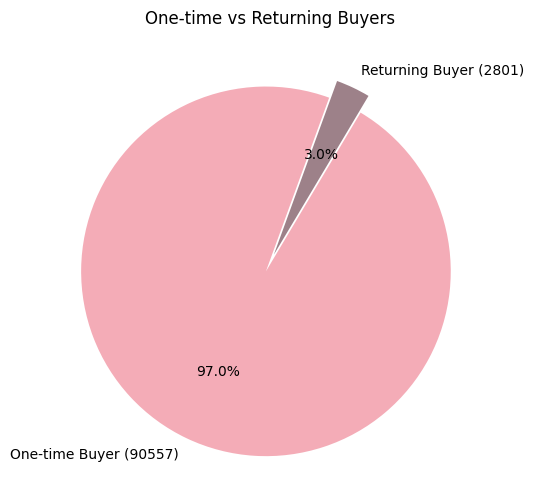

In [164]:
import matplotlib.pyplot as plt

labels = buyer_types['customer_type'] + ' (' + buyer_types['num_customers'].astype(str) + ')'
sizes = buyer_types['num_customers']
colors = ['#f4acb7', '#9d8189']
explode = (0.05, 0.05)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=70,
        colors=colors, explode=explode)
plt.title('One-time vs Returning Buyers')
plt.show()

### **🔎 Observation**
- One-time Buyers: **90,557 (97%)**  
- Returning Buyers: **2,801 (3%)**  
- The vast majority of customers made only a single purchase and did not return.  

### **💡 Insight**
- **Retention Challenge**: With 97% of customers purchasing only once, overall loyalty to the platform is very low.  
- **Business Risk**: Heavy reliance on continuous customer acquisition (CAC) may threaten sustainability if customer lifetime value (LTV) remains low.  
- **Possible Causes**:  
  - **Product nature**: Higher share of non-recurring categories (e.g., furniture, appliances).  
  - **Marketplace dynamics**: Customers may treat Olist as a one-time platform rather than building brand loyalty.  
  - **Customer experience issues**: Delivery delays or dissatisfaction with product quality may discourage repeat purchases.  
- **Strategic Implication**: The small portion of returning buyers (3%) will be critical in RFM segmentation as potential targets for loyalty programs and VIP retention strategies.  

## 5-2. Pareto Analysis

### **📍 Purpose**

For verifying whether the principle that *“20% of customers generate 80% of total revenue”* holds true.

 **📚 Pareto Principle**

 The Pareto Principle states that **roughly 80% of outcomes come from 20% of causes**.  
In business, this means:
- 80% of sales often come from 20% of customers or products  
- 80% of problems often arise from 20% of causes  

**Method:**
1. Calculate each customer’s total spending (`SUM(payment_value)`).
2. Sort customers in descending order by revenue.
3. Compute cumulative percentage of revenue.
4. Check what percentage of revenue is contributed by the top 20% of customers.

### **📂 SQL - Customer's total spending**

In [165]:
# 1. Calcuate each customer's total spending & 2. Sort customers in descending order by revenue.
query = '''
SELECT  c.customer_unique_id,
        ROUND(SUM(p.payment_value), 2) AS total_spent
FROM    customers as C JOIN orders AS O
        ON c.customer_id = o.customer_id
        JOIN order_payments as p ON o.order_id = p.order_id
WHERE   o.order_status = 'delivered'
GROUP BY c.customer_unique_id
ORDER BY total_spent desc;
'''

customer_spending = pd.read_sql_query(query, conn)
customer_spending

,customer_unique_id,total_spent
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31
4,459bef486812aa25204be022145caa62,6922.21
...,...,...
93352,6f5b9d1cdccc4d28f0483a612edecacf,11.63
93353,2878e5b88167faab17d4fb83a986d38b,11.63
93354,b33336f46234b24a613ad9064d13106d,10.89
93355,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07


### **📚 Pareto Analysis**

In [166]:
# Cumulative revenue ratio calculation
customer_spending['cum_revenue'] = customer_spending['total_spent'].cumsum()
customer_spending['cum_revenue_pct'] = 100 * customer_spending['cum_revenue'] / customer_spending['total_spent'].sum()

# Cumulative customer ratio calculation
customer_spending['cum_customer_pct'] = 100*(customer_spending.index +1) /len(customer_spending)

# Check the 20% mark
pareto_cut = customer_spending[customer_spending['cum_customer_pct'] <= 20]
pareto_revenue_share = pareto_cut['total_spent'].sum() / customer_spending['total_spent'].sum() * 100
print('20% Mark:', round(pareto_revenue_share,2),'%')


20% Mark: 53.52 %


### **🔎 Observation**
- Total customers analyzed: **93,357**  
- The **top 20% of customers** contributed **53.5% of total revenue**.  
- Distribution is skewed, but not as extreme as the traditional 80/20 rule.  

### **💡 Insight**
- **Revenue Concentration**: A relatively small group of customers generates more than half of the revenue, showing clear evidence of high-value customer concentration.  
- **Deviation from 80/20 Rule**: Instead of 20% driving 80% of revenue, here 20% account for about 53%, suggesting that value is more evenly distributed among the customer base than typical Pareto cases.  
- **Strategic Implication**:  
  - High-spending customers are still critical for revenue stability and should be the primary focus of loyalty programs.  
  - However, the less extreme skew indicates opportunities to increase engagement among mid-tier customers, as they collectively represent a significant portion of revenue.  
  - Future campaigns can test whether mid-tier segments can be shifted toward higher spending or greater purchase frequency.  

## 5-3. Customer Lifecycle & Cohort Retention

**📚 Customer Lifecycle:** The period (in days) between a customer’s first and last purchase.  
If most customers are one-time buyers, many lifecycles will be **0 days**, whereas loyal customers will have longer lifecycles.  
- **Unit of measurement:** Individual customer  

**📚 Cohort Retention:** The percentage of customers who made their first purchase at a specific time (e.g., a given month) and continued to make repeat purchases in the following months.  
It helps reveal whether customers stay on the platform or churn.  
- **Unit of measurement:** Customer group (cohort)  


### **📍 Purpose**  
- Customer Lifecycle Analysis helps identify customer loyalty patterns and distinguish between one-time buyers and long-term customers.

- Cohort Retention Analysis allows you to track how well different customer cohorts are retained over time, revealing trends in customer engagement and churn.

Together, these analyses show how long customers stay active and how effectively the business retains customers over time, which is essential for improving customer lifetime value (CLV), retention strategies, and marketing efficiency.

### **📂 SQL - Customer Lifecycle**


In [167]:
# Customer Lifecycle

query = '''
SELECT  c.customer_unique_id,
        DATE(MIN(o.order_purchase_timestamp)) AS first_order,
        DATE(MAX(o.order_purchase_timestamp)) AS last_order,
        JULIANDAY(MAX(o.order_purchase_timestamp)) - JULIANDAY(MIN(o.order_purchase_timestamp)) as lifecycle_days
FROM    customers as C JOIN orders as o ON c.customer_id = o.customer_id
WHERE   o.order_status = 'delivered'
GROUP BY c.customer_unique_id
ORDER BY lifecycle_days DESC;

'''


lifecycle = pd.read_sql_query(query, conn)
lifecycle

,customer_unique_id,first_order,last_order,lifecycle_days
0,32ea3bdedab835c3aa6cb68ce66565ef,2016-10-03,2018-06-28,633.084190
1,ccafc1c3f270410521c3c6f3b249870f,2016-10-06,2018-06-07,608.978912
2,d8f3c4f441a9b59a29f977df16724f38,2017-01-18,2018-08-24,582.864363
3,94e5ea5a8c1bf546db2739673060c43f,2016-10-05,2018-05-09,580.693322
4,87b3f231705783eb2217e25851c0a45d,2016-10-08,2018-05-04,572.686840
...,...,...,...,...
93353,0004aac84e0df4da2b147fca70cf8255,2017-11-14,2017-11-14,0.000000
93354,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,2017-10-12,0.000000
93355,0000f46a3911fa3c0805444483337064,2017-03-10,2017-03-10,0.000000
93356,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,0.000000


### **📚 Cohort Retention**

In [168]:
# Cohort Retention

# Order data
query = '''
SELECT c.customer_unique_id, DATE(o.order_purchase_timestamp) AS order_date
FROM   customers as c JOIN orders as o ON c.customer_id = o.customer_id
WHERE  o.order_status = 'delivered';
'''

order_data = pd.read_sql_query(query, conn)

# Create Monthly columns
order_data['order_month'] = pd.to_datetime(order_data['order_date']).dt.to_period('M')

# Create Cohort month (the first purchase month for each customer)
order_data['cohort_month'] = order_data.groupby('customer_unique_id')['order_month'].transform('min')

# Create Cohort index (number of months since the cohort month)
from operator import attrgetter
order_data['cohort_index'] = (order_data['order_month'] - order_data['cohort_month']).apply(attrgetter('n'))

order_data


,customer_unique_id,order_date,order_month,cohort_month,cohort_index
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,2017-10,2017-09,1
1,af07308b275d755c9edb36a90c618231,2018-07-24,2018-07,2018-07,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,2018-08,2018-08,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18,2017-11,2017-11,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13,2018-02,2018-02,0
...,...,...,...,...,...
96473,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09,2017-03,2017-03,0
96474,da62f9e57a76d978d02ab5362c509660,2018-02-06,2018-02,2018-02,0
96475,737520a9aad80b3fbbdad19b66b37b30,2017-08-27,2017-08,2017-08,0
96476,5097a5312c8b157bb7be58ae360ef43c,2018-01-08,2018-01,2018-01,0


In [169]:
# Pivot table (customers per cohort and month index)
cohort_data = order_data.groupby(['cohort_month','cohort_index'])['customer_unique_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_unique_id')

# Calculate retention rate
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)
retention

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05,1.0,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,0.002608,0.002608,0.002608,0.003477,0.002318,0.000290,0.001739,0.002028,NaN,NaN,NaN,NaN
2017-06,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


### 📝 Cohort Table Interpretation

**1. Table Structure**
- row (**cohort_month**): The month when the customer made their first purchase
- column (**cohort_index**): How many months have passed since the first purchase  
Ex.
>0 = First purchase month  
>1 = Month after the first purchase  
>2 = Second month after the first purchase

**2. Value = Retention Rate**  
value(retention rate) = Number of active customers in that month from the cohort ÷ Number of customers in the cohort's first month

Ex. 2017-01 cohort
> Column 0 = 1.0 → 100% of customers in the first month (this is the baseline month)  
> Column 1 = 0.002789 → Only 0.28% of the first-month customers made a purchase in the second month  
> Column 2 = 0.002789 → About 0.28% remained active in the third month as well  
> The values gradually decrease afterward → **Customer churn**



### **🔎 Observation**
- Across all cohorts, retention rate drops sharply below 1% after the first month.  
- By the third month, customer retention approaches zero across nearly every cohort.  
- Customer lifecycle is extremely short: for the majority of buyers, the first purchase is also the last purchase.  
- Only a very small subset of customers (≤0.5% per cohort) remain active beyond 4–5 months.  



### **💡 Insight**
- **New Acquisition Dependency**  
  Growth is almost entirely driven by new customer acquisition rather than repeat purchases. This suggests potential overspending on acquisition marketing (CAC) without securing long-term value.  

- **Weak Customer Loyalty**  
  Near-zero retention after three months indicates weak stickiness or habit formation. Possible reasons include:  
  - Product mix dominated by non-recurring goods (e.g., furniture, appliances, electronics)  
  - Marketplace seen as a one-time intermediary rather than a return-worthy brand  
  - Customer experience issues (long delivery times, inconsistent seller quality)  

- **Strategic Priority**  
  Retention uplift is critical for survival. Even a small increase (e.g., from 3% to 8% repeat rate) could significantly improve LTV and reduce pressure on CAC.  

- **High-Value Segment**  
  Loyal customers are scarce, so identifying the **Frequency > 1** group via RFM segmentation is essential. This small segment may generate a disproportionately large share of revenue and form the base for loyalty or membership programs.  

- **Business Implication**  
  Without initiatives like loyalty programs, personalized reactivation campaigns, or subscription/bundle models, the platform risks plateauing or even declining despite growing gross sales volume.  

## 5-4. Sales by category

### **📍 Purpose**  
From the previous analyses, we observed that
1. Olist’s customer base is dominated by one-time buyers.
2. revenue is concentrated among a small segment.
3. long-term retention is almost nonexistent.

Before moving on to RFM segmentation, I will first examine which product categories customers tend to purchase.

This step helps us distinguish high-revenue categories from less popular ones and provides a foundation for interpreting RFM segments in relation to which product categories loyal customers are associated with.

### **📂 SQL - Sales by Category**

In [170]:
query = '''
SELECT  t.product_category_name_english AS category,
        ROUND(SUM(op.payment_value), 2) AS total_revenue,
        COUNT(DISTINCT o.order_id) as num_orders,
        COUNT(DISTINCT c.customer_unique_id) as num_customers
FROM    orders as o join order_items as i ON o.order_id = i.order_id
        JOIN products as p ON i.product_id = p.product_id
        JOIN product_category_name_translation as t ON p.product_category_name = t.product_category_name
        JOIN order_payments as op ON o.order_id = op.order_id
        JOIN customers as c ON o.customer_id = c.customer_id
WHERE   o.order_status = 'delivered'
GROUP BY category
ORDER BY total_revenue DESC
LIMIT 10;
'''

category_revenue=pd.read_sql_query(query, conn)
category_revenue

,category,total_revenue,num_orders,num_customers
0,bed_bath_table,1692714.28,9272,9008
1,health_beauty,1620684.04,8646,8497
2,computers_accessories,1549372.59,6530,6405
3,furniture_decor,1394466.93,6307,6178
4,watches_gifts,1387362.45,5495,5421
5,sports_leisure,1349446.93,7530,7341
6,housewares,1069787.97,5743,5681
7,auto,833745.67,3810,3769
8,garden_tools,810614.93,3448,3420
9,cool_stuff,744649.32,3559,3543


### **📊 Bar chart**

/tmp/ipython-input-1050200800.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="total_revenue", y="category", data=data, palette="PuBuGn")


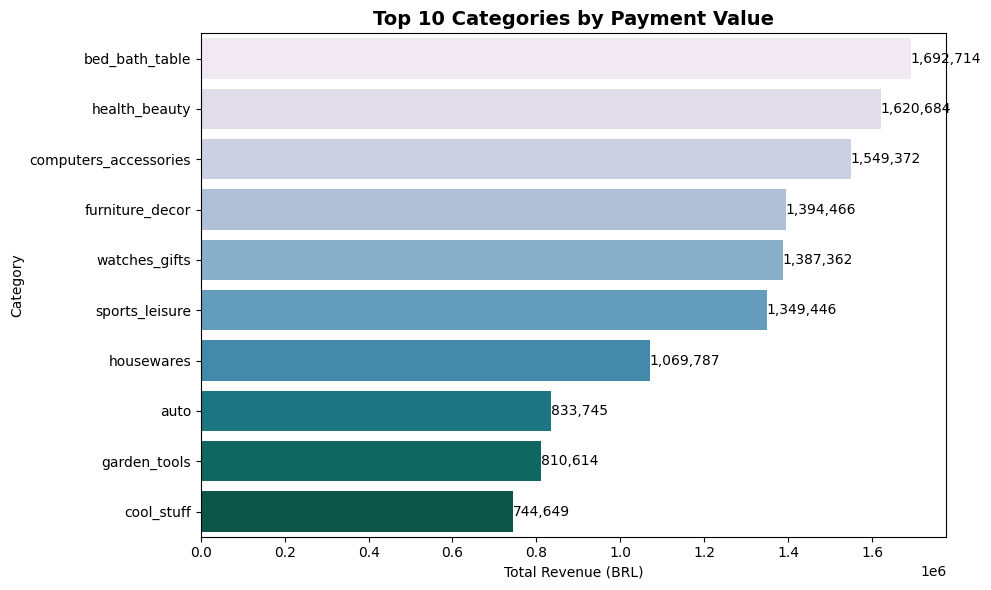

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

data = category_revenue.sort_values(by='total_revenue', ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x="total_revenue", y="category", data=data, palette="PuBuGn")

for i, v in enumerate(data['total_revenue']):
    ax.text(v, i, f"{int(v):,}", va='center', fontsize=10)

plt.title("Top 10 Categories by Payment Value", fontsize=14, fontweight='bold')
plt.xlabel("Total Revenue (BRL)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

### **🔎 Observation**

Top 3 categories(BRL):
- bed_bath_table (1.69M)
- health_beauty (1.62M)
- computers_accessories (1.54M)

The leading categories are mostly low-cost, low-involvement consumer goods.
While higher-value categories such as furniture_decor exist, they rank only fourth in total revenue.
This indicates that the top revenue drivers are dominated by products that are often one-time, transactional purchases.

### **💡 Insight**

- This purchasing pattern reinforces the high proportion of one-time buyers and the platform’s low retention.
- It will be essential to examine, through RFM analysis, whether loyal customers are concentrated in specific categories.
- If loyal customers are found in high-involvement categories (e.g., furniture, sports), targeted loyalty programs or personalized promotions could be effective.
- Conversely, if loyal segments are concentrated in consumer goods categories, subscription models or bundling strategies may help encourage repeat purchases.

Based on these findings, we now turn to RFM segmentation to identify distinct customer groups. While the category analysis highlights what customers purchase, RFM will help us understand who the most valuable customers are, and how their recency, frequency, and monetary value differ across segments. This will provide a clearer foundation for designing retention and loyalty strategies.

# **6. RFM Segmentation**

### **📚 RFM Analysis**
RFM (Recency, Frequency, Monetary) is a customer segmentation technique that evaluates:  
- **Recency**: How recently a customer made a purchase  
- **Frequency**: How often a customer makes purchases  
- **Monetary**: How much money a customer spends  

**Purpose:** Identify high-value customers (e.g., loyal or VIPs), detect churn risks, and design targeted marketing strategies such as loyalty programs or reactivation campaigns.


### **📂 SQL - Recency, Frequency, Monetary**

In [172]:
# Recency
query = '''
SELECT  c.customer_unique_id,
        MAX(o.order_purchase_timestamp) AS last_purchase_date
FROM    orders o JOIN customers c
        ON o.customer_id = c.customer_id
GROUP BY c.customer_unique_id;
'''

recency = pd.read_sql_query(query,conn)
recency


,customer_unique_id,last_purchase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


In [173]:
# Frequency
query = '''
SELECT  c.customer_unique_id,
        COUNT(o.order_id) AS frequency
FROM    orders o JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_unique_id;
'''

frequency = pd.read_sql_query(query,conn)
frequency


,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,1
96092,fffea47cd6d3cc0a88bd621562a9d061,1
96093,ffff371b4d645b6ecea244b27531430a,1
96094,ffff5962728ec6157033ef9805bacc48,1


In [174]:
# Monetary
query = '''
SELECT  c.customer_unique_id,
        ROUND(SUM(p.payment_value), 2) AS monetary
FROM    orders o JOIN customers c ON o.customer_id = c.customer_id
        JOIN order_payments p ON o.order_id = p.order_id
GROUP BY c.customer_unique_id;
'''

monetary = pd.read_sql_query(query, conn)
monetary

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,84.58
96092,ffff371b4d645b6ecea244b27531430a,112.46
96093,ffff5962728ec6157033ef9805bacc48,133.69


### **📂 SQL - RFM Table**

In [175]:
# RFM
query = '''

WITH recency AS (
    SELECT  c.customer_unique_id,
            MAX(o.order_purchase_timestamp) AS last_purchase_date
    FROM    orders o JOIN customers c
            ON o.customer_id = c.customer_id
    GROUP BY c.customer_unique_id
),
frequency AS (
    SELECT  c.customer_unique_id,
            COUNT(o.order_id) AS frequency
    FROM    orders o JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY c.customer_unique_id
),
monetary AS (
    SELECT  c.customer_unique_id,
            ROUND(SUM(p.payment_value), 2) AS monetary
    FROM    orders o JOIN customers c ON o.customer_id = c.customer_id
            JOIN order_payments p ON o.order_id = p.order_id
    GROUP BY c.customer_unique_id
)
SELECT
    r.customer_unique_id,
    julianday('2018-09-01') - julianday(r.last_purchase_date) AS recency,
    f.frequency,
    m.monetary
FROM recency r JOIN frequency f ON r.customer_unique_id = f.customer_unique_id
     JOIN monetary m ON r.customer_unique_id = m.customer_unique_id;
'''

rfm = pd.read_sql_query(query, conn)
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113.544132,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116.533715,1,27.19
2,0000f46a3911fa3c0805444483337064,539.121493,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,323.146053,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,290.176597,1,196.89
...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,449.124583,1,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,264.161157,1,84.58
96092,ffff371b4d645b6ecea244b27531430a,570.340787,1,112.46
96093,ffff5962728ec6157033ef9805bacc48,121.362720,1,133.69


In [176]:
# Recency: The lower, the higher the score.
# recent purchase = 5 points, long ago = 1 point
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])

# Frequency: more purchases = higher score (5 points)
# use absolute bins instead of qcut, because most customers are one-time buyers
rfm['F_score'] = pd.cut(
    rfm['frequency'],
    bins=[0,1,2,3,5, rfm['frequency'].max()],
    labels=[1,2,3,4,5],
    include_lowest=True
)

# Monetary: use cut instead of qcut (absolute bins)
rfm['M_score'] = pd.cut(
    rfm['monetary'],
    bins=[-1, 100, 200, 400, 1000, rfm['monetary'].max()],
    labels=[1,2,3,4,5],
    include_lowest=True
)

# RFM Score: concatenate as string
rfm['RFM_score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm.head()

,customer_unique_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,113.544132,1,141.90,4,1,2,412
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116.533715,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,539.121493,1,86.22,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,323.146053,1,43.62,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,290.176597,1,196.89,2,1,2,212


## 📚 RFM Scoring Explanation

### Recency (R)
- **Distribution**: Recency values (days since last purchase) are relatively evenly spread across customers.  
- **Scoring method**: Applied `pd.qcut` to split into 5 quantiles, assigning scores from **5 (most recent)** to **1 (longest ago)**.  
- **Reason**: Since recency is continuous and evenly distributed, quantile-based grouping captures relative recency effectively.  

---

### Frequency (F)
- **Distribution**: ~97% of customers purchased only once, while a very small fraction purchased multiple times.  
- **Scoring method**: Used `pd.cut` with absolute bins **([1,2,3–5,6–10,11+])**, assigning scores from **1 to 5**.  
- **Reason**: Quantiles would artificially split one-time buyers into different groups. Absolute bins ensure that frequency scores reflect **real purchase behavior** instead of distorted quantile splits.  

---

### Monetary (M)
- **Distribution**:  
  - 50% of customers spend less than **108 BRL**.  
  - 75% spend less than **184 BRL**.  
  - 95% spend less than **476 BRL**, while only ~1% spend more than **1,100 BRL**.  
  - The distribution is **highly right-skewed**.  
- **Scoring method**: Applied `pd.cut` with bins **[-1,100,200,400,1000,max]**, mapping to scores **1–5**.  
- **Reason**: Cut-based bins separate the **large base of low spenders** from the **small group of high-value customers**, ensuring the Monetary score highlights true VIPs while maintaining comparability across groups.  


In [177]:
# check the distribuiton of monetary
rfm['monetary'].describe(percentiles=[.25, .5, .75, .9, .95, .99])


,monetary
count,96095.000000
mean,166.594226
std,231.428912
min,0.000000
25%,63.120000
50%,108.000000
75%,183.530000
90%,319.570000
95%,476.152000
99%,1122.466200


In [178]:
# Distribution of scores
print(rfm['R_score'].value_counts())
print(rfm['F_score'].value_counts())
print(rfm['M_score'].value_counts())

R_score
5    19219
4    19219
3    19219
2    19219
1    19219
Name: count, dtype: int64
F_score
1    93098
2     2745
3      203
4       38
5       11
Name: count, dtype: int64
M_score
1    44394
2    30953
3    14317
4     5213
5     1218
Name: count, dtype: int64


## **6-1. Customer Segmentation**

**Customer Segmentation Definition**
1. **Champions**  
   - Definition: Recently purchased, purchase often, and spend a lot  
   - Criteria: R ≥ 4, F ≥ 3, M ≥ 3  

2. **Loyal Customers**  
   - Definition: Customers who purchase frequently and relatively recently  
   - Criteria: R ≥ 4, F ≥ 2  

3. **Big Spenders**  
   - Definition: High-spending customers  
   - Criteria: Monetary ≥ 300 BRL  

4. **At Risk**  
   - Definition: Haven’t purchased recently, but used to purchase often  
   - Criteria: R ≤ 2, F ≥ 2  

5. **New Customers**  
   - Definition: Customers who made their first purchase recently  
   - Criteria: R = 5, F = 1  

6. **Lost Customers**  
   - Definition: Customers who left after purchasing a long time ago  
   - Criteria: R ≤ 2, F = 1  

7. **Promising**  
   - Definition: Customers who made a recent purchase but with low frequency and spending  
   - Criteria: R ≥ 4, F = 1, M ≤ 2  

In [179]:
def segment_customer(row):
    if row['R_score'] >= 4 and row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'Champions'
    elif row['R_score'] >= 4 and row['F_score'] >= 2:
        return 'Loyal Customers'
    elif row['monetary'] >= 300:
        return 'Big Spenders'
    elif row['R_score'] <= 2 and row['F_score'] >= 2:
        return 'At Risk'
    elif row['R_score'] == 5 and row['F_score'] == 1:
        return 'New Customers'
    elif row['R_score'] == 1:
        return 'Lost Customers'
    else:
        return 'Promising'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm

,customer_unique_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113.544132,1,141.90,4,1,2,412,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116.533715,1,27.19,4,1,1,411,Promising
2,0000f46a3911fa3c0805444483337064,539.121493,1,86.22,1,1,1,111,Lost Customers
3,0000f6ccb0745a6a4b88665a16c9f078,323.146053,1,43.62,2,1,1,211,Promising
4,0004aac84e0df4da2b147fca70cf8255,290.176597,1,196.89,2,1,2,212,Promising
...,...,...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,449.124583,1,2067.42,1,1,5,115,Big Spenders
96091,fffea47cd6d3cc0a88bd621562a9d061,264.161157,1,84.58,3,1,1,311,Promising
96092,ffff371b4d645b6ecea244b27531430a,570.340787,1,112.46,1,1,2,112,Lost Customers
96093,ffff5962728ec6157033ef9805bacc48,121.362720,1,133.69,4,1,2,412,Promising


In [180]:
segment_summary = rfm.groupby('Segment').agg({
    'customer_unique_id':'count',
    'monetary':'sum'
}).rename(columns={
    'customer_unique_id':'num_customers',
    'monetary':'total_revenue'
}).reset_index()

# Calculate the percentage of total revenue contributed by each segmen
segment_summary['revenue_share'] = (
    segment_summary['total_revenue'] / segment_summary['total_revenue'].sum() * 100
).round(2)

segment_summary.sort_values(by='total_revenue', ascending=False)

,Segment,num_customers,total_revenue,revenue_share
1,Big Spenders,10292,6240481.15,38.98
6,Promising,50429,5574525.02,34.82
5,New Customers,16588,1837294.56,11.48
3,Lost Customers,16756,1805755.28,11.28
4,Loyal Customers,1185,350055.10,2.19
0,At Risk,726,120681.97,0.75
2,Champions,119,80079.04,0.50


In [187]:
segment_summary = rfm.groupby('Segment').agg({
    'customer_unique_id': 'count',
    'monetary': 'sum'
}).rename(columns={
    'customer_unique_id': 'num_customers',
    'monetary': 'total_revenue(BRL)'
}).reset_index()

# Number of total customers
total_customers = segment_summary['num_customers'].sum()

# Total Revenue
total_revenue = segment_summary['total_revenue(BRL)'].sum()

# Calculate Ratio
segment_summary['customer_share(%)'] = (
    segment_summary['num_customers'] / total_customers * 100
).round(2)

segment_summary['revenue_share(%)'] = (
    segment_summary['total_revenue(BRL)'] / total_revenue * 100
).round(2)

segment_summary = segment_summary.sort_values(by='total_revenue(BRL)', ascending=False)

segment_summary


,Segment,num_customers,total_revenue(BRL),customer_share(%),revenue_share(%)
1,Big Spenders,10292,6240481.15,10.71,38.98
6,Promising,50429,5574525.02,52.48,34.82
5,New Customers,16588,1837294.56,17.26,11.48
3,Lost Customers,16756,1805755.28,17.44,11.28
4,Loyal Customers,1185,350055.10,1.23,2.19
0,At Risk,726,120681.97,0.76,0.75
2,Champions,119,80079.04,0.12,0.50


### **🔎 Observations**

**1. Customer Distribution**  
- **Promising customers** dominate the base, making up **52.5%** of all customers.  
- **New Customers (17.3%)** and **Lost Customers (17.4%)** together account for ~35%, meaning acquisition is almost offset by churn.  
- **Champions (0.1%)** and **Loyal Customers (1.2%)** are extremely rare.  

**2. Revenue Contribution**  
- **Big Spenders** generate the largest share, contributing **39%** of total revenue.  
- **Promising customers** represent the majority in number but only **34.8%** of revenue, reflecting many recent but low-frequency and low-value purchases.  
- **Champions** contribute just **0.5%** of total revenue.  

**3. Customer vs. Revenue Imbalance**  
- **Promising customers** are numerous but inefficient in revenue contribution.  
- **Big Spenders** account for only **10.7%** of customers but contribute **39%** of revenue.  
- **Lost** and **New Customers** each represent ~17% of customers but only ~11% of revenue, making them the least efficient segments.  

### **💡 Insights**

**1. Core Revenue Drivers**  
- **Big Spenders** are the most critical segment, driving nearly 40% of revenue.  
- Retention and VIP-focused strategies are essential for maintaining revenue stability.  

**2. Growth Potential**  
- **Promising customers** are large in number but underperforming in value.  
- With upselling and retention initiatives, many could be converted into **Champions or Big Spenders**, creating strong long-term growth.  

**3. Risk Factors**  
- **Lost Customers (17%)** show evidence of past engagement and are viable reactivation targets.  
- However, their low revenue share (~11%) requires cost-efficient campaigns.  

**4. Structural Weakness**  
- **Champions and Loyal Customers** combined are only ~1.3% of the base.  
- This reflects a weak loyalty foundation and shows the platform is treated primarily as a one-time purchase marketplace.  


## **6-2. Segmentation Visualization**

### **📊 Pie Chart: Customer Distribution**

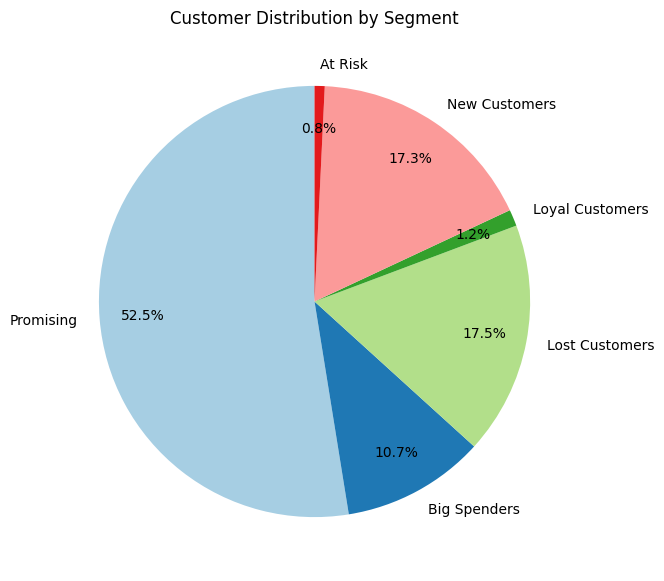

In [205]:
sorted_data = segment_summary.sort_values(by="num_customers", ascending=False).reset_index(drop=True)

half = len(sorted_data) // 2
big_segments = sorted_data.iloc[:half].reset_index(drop=True)
small_segments = sorted_data.iloc[half:].reset_index(drop=True)

reordered_list = []
for b, s in zip(big_segments.iterrows(), small_segments.iterrows()):
    reordered_list.append(b[1])
    reordered_list.append(s[1])

if len(big_segments) > len(small_segments):
    for i in range(len(small_segments), len(big_segments)):
        reordered_list.append(big_segments.iloc[i])

reordered_data = pd.DataFrame(reordered_list)

plt.figure(figsize=(7,7))
plt.pie(
    reordered_data['num_customers'],
    labels=reordered_data['Segment'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Paired", len(reordered_data)),
    pctdistance=0.8
)
plt.title("Customer Distribution by Segment")
plt.show()


### **📊 Bar Chart: Revenue Contribution**

/tmp/ipython-input-2044452282.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


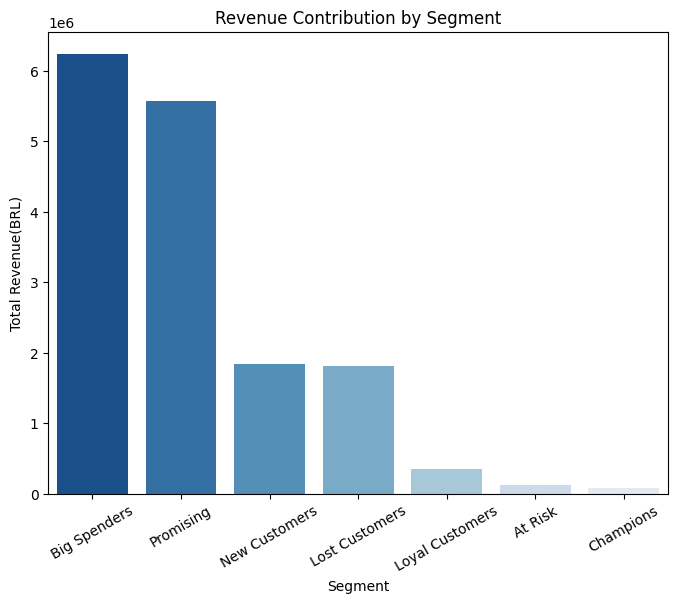

In [210]:
plt.figure(figsize=(8,6))
sns.barplot(
    x="Segment",
    y="total_revenue(BRL)",
    data=segment_summary,
    palette="Blues_r"
)
plt.title("Revenue Contribution by Segment")
plt.ylabel("Total Revenue(BRL)")
plt.xticks(rotation=30)
plt.show()

### **📊 Heatmap: RFM Matrix**

/tmp/ipython-input-3316057416.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_matrix = rfm.pivot_table(


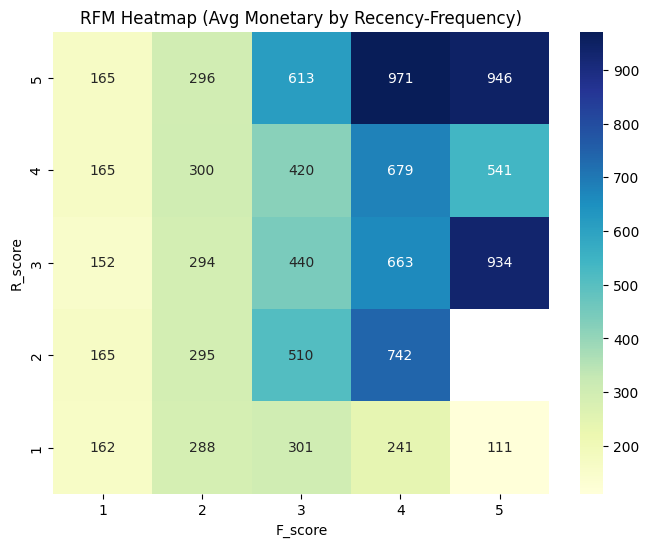

In [206]:
# pivot table for Recency-Frequency with Monetary mean
rfm_matrix = rfm.pivot_table(
    index='R_score',
    columns='F_score',
    values='monetary',
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(
    rfm_matrix,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu"
)
plt.title("RFM Heatmap (Avg Monetary by Recency-Frequency)")
plt.show()

F5,R2: Empty cells indicate that no customers fall into the corresponding Recency–Frequency segment.

### **📊 Bar chart: Customer vs Revenue Share**

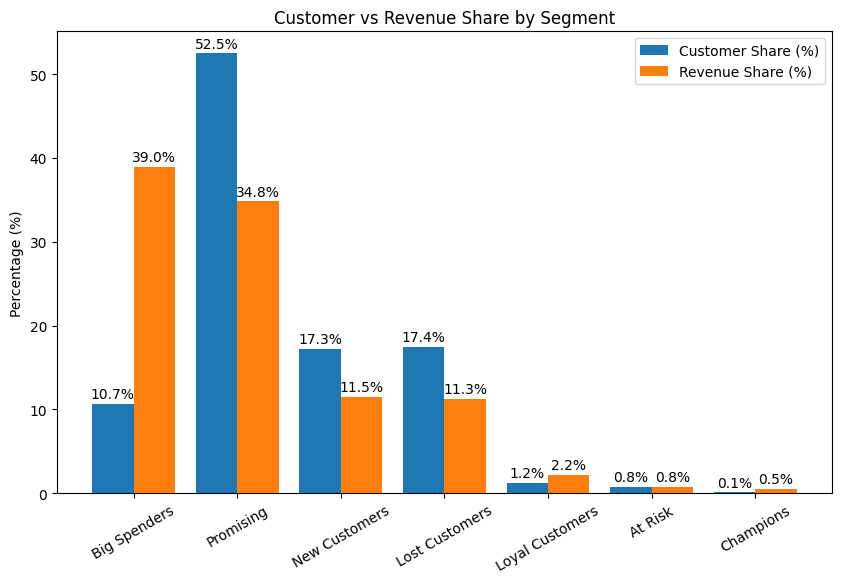

In [218]:
plt.figure(figsize=(10,6))
x = np.arange(len(segment_summary))
width = 0.4

bars1 = plt.bar(x - width/2, segment_summary['customer_share(%)'], width=width, label='Customer Share (%)')
bars2 = plt.bar(x + width/2, segment_summary['revenue_share(%)'], width=width, label='Revenue Share (%)')

plt.bar_label(bars1, fmt="%.1f%%", padding=2)
plt.bar_label(bars2, fmt="%.1f%%", padding=2)

plt.xticks(x, segment_summary['Segment'], rotation=30)
plt.ylabel("Percentage (%)")
plt.title("Customer vs Revenue Share by Segment")
plt.legend()
plt.show()

# **7. Segment-Specific Strategies (Action Plan)**

The RFM segmentation highlights key opportunities and risks in the customer base.  
To translate these insights into actionable strategies, we propose the following directions:  

- **VIP Customer Retention**: Loyalty programs and personalized offers to strengthen engagement among Champions and Loyal Customers.  
- **Retention of At-Risk Customers**: Reactivation campaigns to win back customers who previously purchased but are now inactive.  
- **Upselling/ Bundling for Big Spenders**: Targeted offers to maximize revenue from high-value customers.  
- **Conversion of Promising Customers**: Engagement campaigns (upsell, coupons, cross-sell) to turn the large Promising segment into repeat buyers and future Champions.  

The table below summarizes specific strategic actions for each segment:


In [219]:
data = {
    "Segment": [
        "Champions", "Loyal Customers", "Big Spenders",
        "Promising", "New Customers", "At Risk", "Lost Customers"
    ],
    "Characteristics": [
        "Very recent, frequent, and high spenders (0.1%)",
        "Recent and frequent, moderate spenders (1.2%)",
        "Small group (10.7%) but 39% of revenue",
        "Largest group (52.5%) but low frequency/spending",
        "First purchase recently (17.3%)",
        "Used to purchase, now inactive (small share)",
        "Haven’t purchased for a long time (17.4%)"
    ],
    "Strategic Actions": [
        "Exclusive VIP program, Reviews & Referrals",
        "Tiered loyalty program, Reviews & Referrals",
        "Personalized recommendations, Bundle offers, B2B account mgmt",
        "Upsell & cross-sell campaigns, Triggered coupons",
        "Welcome emails, Personalized recommendations",
        "Win-back campaigns, Highlight service improvements",
        "Cost-effective retargeting, Exclude low-value customers"
    ]
}

df_segments = pd.DataFrame(data)

pd.set_option('display.max_colwidth', None)
df_segments


,Segment,Characteristics,Strategic Actions
0,Champions,"Very recent, frequent, and high spenders (0.1%)","Exclusive VIP program, Reviews & Referrals"
1,Loyal Customers,"Recent and frequent, moderate spenders (1.2%)","Tiered loyalty program, Reviews & Referrals"
2,Big Spenders,Small group (10.7%) but 39% of revenue,"Personalized recommendations, Bundle offers, B2B account mgmt"
3,Promising,Largest group (52.5%) but low frequency/spending,"Upsell & cross-sell campaigns, Triggered coupons"
4,New Customers,First purchase recently (17.3%),"Welcome emails, Personalized recommendations"
5,At Risk,"Used to purchase, now inactive (small share)","Win-back campaigns, Highlight service improvements"
6,Lost Customers,Haven’t purchased for a long time (17.4%),"Cost-effective retargeting, Exclude low-value customers"


# **8. Conclusion**

**1. Key Insights**  
The customer base is heavily concentrated in **Promising** and **New/Lost Customers**, while the loyal segments (**Champions** and **Loyal Customers**) remain very weak. In contrast, **Big Spenders**, though small in number, contribute a disproportionately large share of total revenue.  


**2. Limitations**  
This analysis is limited to a specific transaction period, making it difficult to capture long-term customer behavior. In addition, the absence of cost-related data such as **Customer Acquisition Cost (CAC)** and marketing spend prevents ROI-based strategy evaluation.  


**3. Additional Areas for Exploration**  
- **Customer Lifetime Value (LTV) Modeling**: Estimate each customer’s future value to allocate marketing resources more efficiently toward high-value customers.  
- **Personalized Recommendation System**: Deliver tailored product suggestions to Promising customers, encouraging them to convert into Champions or Big Spenders.  
- **Predictive Analytics**: Use machine learning to anticipate churn risk and purchase likelihood, enabling proactive retention strategies.  

# **9. (Appendix) Summary**

- **Customer Segmentation (RFM):**  
  Customers were classified into 7 segments (Champions, Loyal, Big Spenders, Promising, New, At Risk, Lost).  
  The majority fall into **Promising (52.5%)**, while **Champions (0.1%)** and **Loyal Customers (1.2%)** are very limited.  

- **Revenue Contribution:**  
  **Big Spenders (10.7% of customers)** generate **39% of total revenue**, making them the most valuable segment.  
  Promising customers contribute **34.8%**, but with low efficiency given their size.  

- **Key Observations:**  
  - Customer base is skewed toward One-time buyers(new and low-frequency).  
  - Loyalty foundation is weak, with very few Champions/Loyals.  
  - Strong imbalance between customer share and revenue share.  

- **Strategic Implications:**  
  - Retain and reward high-value customers (VIP/loyalty programs).  
  - Upsell and cross-sell to Promising customers to drive growth.  
  - Targeted reactivation campaigns for At Risk/Lost customers.  
